# Background of the dataset

Enron Corporation was an American energy company, marketing electricity and natural gas and also provided risk management services to curstomers. It was a new-economy company, which was ranked as "most innovative company" several times in a row. Enron had 21000 employees in more than 40 countries.

However, it became infamous for the "enron scandal" in 2001 when it was reveales that their earnings had been overstated by several hundred million dollars. They had been able to hide and manipulate offical accounts over years.
Shortly before the collapse, many top Enron executives began to sell large amounts of stock. The prices dropped from `$85.00` to `$0.30`. More than 20000 people lost their jobs and shareholders lost ten billions of dollars.

One (and probably the only) positive outcome is the release of the Enron email corpus by the Federal Energy Regulatory Commission. They decided to publish it on the internet to serve the public’s interest in the investigations.
The Enron dataset contains about 50.000 emails written by 158 employes of the Enron corporation. It is unique as it is the only publicly available collection of real emails, which means that it shows how real people write real emails and, not as other datasets, contains only randomly generated texts.

The goal of the project is to use a machine learning algorithm to predict the person of interest (POI) of the fraud.

In [202]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [203]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'deferral_payments', 'total_payments',
                'loan_advances', 'bonus', 'restricted_stock_deferred',
                'deferred_income', 'total_stock_value', 'expenses',
                'exercised_stock_options', 'other', 'long_term_incentive',
                'restricted_stock', 'director_fees', 'shared_receipt_with_poi',
                'to_messages', 'from_poi_to_this_person', 'from_messages',
                'from_this_person_to_poi']
                
financial_features = ['salary', 'deferral_payments', 'total_payments',
                'loan_advances', 'bonus', 'restricted_stock_deferred',
                'deferred_income', 'total_stock_value', 'expenses',
                'exercised_stock_options', 'other', 'long_term_incentive',
                'restricted_stock', 'director_fees']

### Data overview

In [204]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

enron_df = pd.DataFrame.from_dict(data_dict,orient='index',dtype=float)
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null float64
director_fees                17 non-null float64
deferred_income              49 non-null fl

There are currently a lot of NaNs in the data. They were entered just as "NaN", so I am replacing them using numpy.

In [205]:
enron_df = enron_df.replace('NaN',np.nan)

### Other characteristics 
* Total number of people: 146
* POI: 8
* Number of features: 20

# Removal of outliers

## Plot of bonus and total payments

Both features 'bonus' and 'total payments' obviously have very high maximum values. I will plot them, so I get a better impression of how the features are distributed.


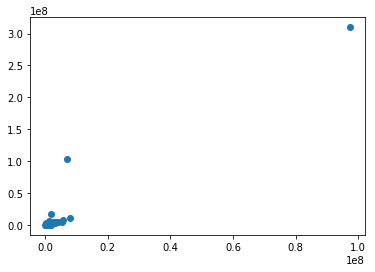

In [206]:
plt.scatter(enron_df['bonus'], enron_df['total_payments'])
plt.show()

There is one extreme outlier, which is easy to recognize as the "Total" row. It will be removed in the next step.

## Removal and replacement of data

I removed the following rows and columns:

1. LOCKHART EUGENE E has only NaN entries.
2. THE TRAVEL AGENCY IN THE PARK and TOTAL are no real persons.
3. The column 'email_address' does not provide any helpful information, so it was removed.


Furthermore, there are several financial features with NaN values. There are basically two ways to handle them:
1. Replace them with 0 if we assume that NaN means that the reason why the value is missing is that there were no payments.
2. Replace them with the mean or median of the other rows if we assume that NaN means that we are missing data.

In this project I decided to take approach 1. I think that the missing values look reasonable to me. For example, there is no entry where a bonus was paid, but no salary. Therefore I decided to replace all NaN with 0.

In [207]:
enron_df = enron_df.drop("LOCKHART EUGENE E", 0)
enron_df = enron_df.drop("THE TRAVEL AGENCY IN THE PARK", 0)
enron_df = enron_df.drop("TOTAL", 0)
enron_df = enron_df.drop('email_address', 1)

enron_df[financial_features] = enron_df[financial_features].fillna(0)

I will creater another plot of the features 'bonus' and 'total payments' to visualize the effect of the replaced outliers.

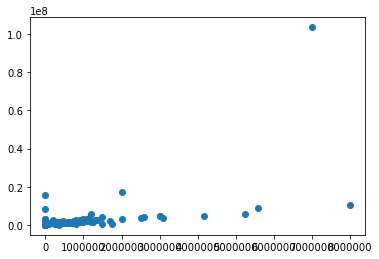

In [208]:
plt.scatter(enron_df['bonus'], enron_df['total_payments'])
plt.show()

In [209]:
print("Maxmium bonus: ", enron_df['bonus'].idxmax())
print("Maximum total payments: ", enron_df['total_payments'].idxmax())

('Maxmium bonus: ', 'LAVORATO JOHN J')
('Maximum total payments: ', 'LAY KENNETH L')


There are still two entries which have a very high amount of bonus or total payments. These are John Lavorato and Kenneth Lay. As these are real persons, this is probably correct and therefore might have an important impact on my results. From my research about the Enron scandal I can also remember that Kenneth Lay played an important roles as the Enron CEO.

In [210]:
enron_df[financial_features] = enron_df[financial_features].fillna(0)
enron_df = enron_df.fillna(enron_df.median().to_dict())

## Create new features

In this section, I will create a new feature. I decided to add three features:
1. Ratio mails from POIs / total from mails
2. Ratio mails to POIs / total to mails
3. Ratio from + to mails to POI / total from + to mails

These new features might give additional information as they represent the ratio between emails sent to and from POIs and the total number of sent/received emails.
Unfortunately, it will later be shown that the new features do not help to improve the overall result.

In [211]:
def from_poi_ratio(row):
    from_poi = row['from_poi_to_this_person']
    from_all = row['from_messages']
    
    n = 0
    
    if from_all > 0:
        n = from_poi / from_all
        
    return n
    
def to_poi_ratio(row):
    to_poi = row['from_this_person_to_poi']
    to_all = row['to_messages']
    
    n = 0
    
    if to_all > 0:
        n = to_poi / to_all
        
    return n


def poi_email_ratio(row):
    to_poi = row['from_this_person_to_poi']
    from_poi = row['from_poi_to_this_person']
    to_all = row['to_messages']
    from_all = row['from_messages']
    
    n = 0
    
    if (to_poi > 0 or to_all > 0):
        n = (to_poi + from_poi) / (to_all + from_all)
    
    return n


enron_df["poi_email_ratio"] = enron_df.apply(lambda row: poi_email_ratio(row), axis=1)
enron_df["to_poi_ratio"] = enron_df.apply(lambda row: to_poi_ratio(row), axis=1)
enron_df["from_poi_ratio"] = enron_df.apply(lambda row: from_poi_ratio(row), axis=1)

features_list.extend(["poi_email_ratio", "to_poi_ratio", "from_poi_ratio"])

#### Converting back to dictionary


In [212]:
my_dataset = enron_df.T.to_dict()

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Selection of features

I will now select the features which we want to use in the following sections. I decided to use SelectKBest, which calculates a score for each feature. I decided to use the default setting (f_classif), which is an classification based on the ANOVA F-value.
For a better overview, I will also plot the results.

[('restricted_stock_deferred', 0.065499652909942141), ('from_messages', 0.18979831001067199), ('deferral_payments', 0.22461127473600989), ('to_messages', 0.86637579918462837), ('director_fees', 2.1263278020077054), ('from_this_person_to_poi', 2.1870709688462124), ('to_poi_ratio', 3.5172968837810221), ('from_poi_ratio', 3.7591699698175916), ('poi_email_ratio', 3.8198160820351332), ('other', 4.1874775069953749), ('from_poi_to_this_person', 4.2258183235864033), ('expenses', 6.0941733106389453), ('loan_advances', 7.1840556582887247), ('shared_receipt_with_poi', 7.3856912248466484), ('total_payments', 8.7727777300916756), ('restricted_stock', 9.2128106219771002), ('long_term_incentive', 9.9221860131898225), ('deferred_income', 11.458476579280369), ('salary', 18.289684043404513), ('bonus', 20.792252047181535), ('total_stock_value', 24.182898678566879), ('exercised_stock_options', 24.815079733218194)]


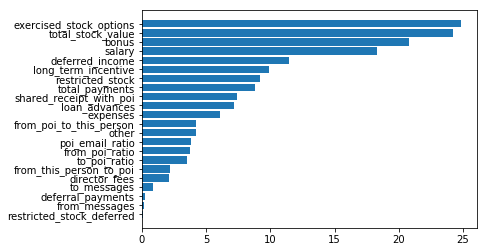

In [213]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
train_test_split(features, labels, test_size=0.3, random_state=42)

## SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif
k = 20
selector = SelectKBest(f_classif, k=k).fit(features, labels)
scores = selector.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(sorted(unsorted_pairs, key=lambda x: x[1]))
k_features, k_scores = map(list, zip(*sorted_pairs))
ind = np.arange(len(k_scores))

print(sorted_pairs)

plt.barh(ind, k_scores)
plt.yticks(ind, k_features)
plt.show()

There are 4 features which have a score below 1 and 3 features above 20. This seems to be a high variance.

After identifying the list of best features, I played around with the algorithms I will present in the next section. I got the best results using the top 6 features, so I will make them them features which I will use in this project.

These features do not include the new features we had added before. They have a comparably low score and are ranked in the lower third.

In [214]:
my_features = ['poi'] + k_features[16:]
print(my_features)

['poi', 'long_term_incentive', 'deferred_income', 'salary', 'bonus', 'total_stock_value', 'exercised_stock_options']


# Algorithm Selection

As a first step, I have selected the best 8 features and used four algorithms with their standard parameters. These are the results:

Algorithm | Accuracy | Precision | Recall
------------ | -------------
Naive Bayes | 0.847 | 0.457 | 0.370
Decision Tree | 0.825 | 0.236 | 0.100
Random Forest | 0.852 | 0.457 | 0.182
AdaBoost | 0.813 | 0.281 | 0.200

All of the algorithms have a high accuracy, but the recall for most of them is rather low. Naive Bayes already fulfills the requirements of >.3 accuracy and recall.
AdaBoost has a recall of 0.200, but I see room for improvement, so I will use it in the following section and try to optimize the result.



# Optimization and Validation

We can see in the results above, we need to improve the recall.
Parameter tuning is a very important step in machine learning. Algorithms require you to set the parameters before using them. While the choice of the best parameters is sometimes obvious when you consider the characterics of the data, it's often a process of testing many settings.

To optimize my results, I will use GridSearchCV. GridSearchCV is really helpful for this goal as it takes care of parameter tuning.

As a first step, I will use MinMaxScaler to scale the selected features to a value between 0 and 1. The features are then fed to the AdaBoostClassifier. For these two steps, GridSearchCV will find the optimal parameters.

In [215]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

pipe = Pipeline([
        ('min_max', MinMaxScaler()),
        ('classify', AdaBoostClassifier())
    ])
    
param_grid = ([
        {
            'classify__n_estimators':[10, 30, 50],
            'classify__algorithm': ['SAMME', 'SAMME.R'],
            'classify__learning_rate': [1.0, 2., 5.],
            'classify__random_state': [42]
        }
    ])

sss = StratifiedShuffleSplit()
clf = GridSearchCV(pipe, param_grid = param_grid, scoring='f1', cv = sss)
clf.fit(features_train, labels_train)

print "(clf.best_estimator_.steps): ", (clf.best_estimator_.steps)
print "(clf.best_score_): ", (clf.best_score_)
print "(clf.best_params_): ", (clf.best_params_)
print "(clf.scorer_): ", (clf.scorer_)

clf = clf.best_estimator_

(clf.best_estimator_.steps):  [('min_max', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=42))]
(clf.best_score_):  0.366666666667
(clf.best_params_):  {'classify__learning_rate': 1.0, 'classify__random_state': 42, 'classify__n_estimators': 10, 'classify__algorithm': 'SAMME.R'}
(clf.scorer_):  make_scorer(f1_score)


In [217]:
pipe = Pipeline([
         ('min_max', MinMaxScaler()),
         ('classify', AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=2.0, n_estimators=10, random_state=42))
     ])

clf = pipe.fit(features_train, labels_train)    

test_classifier(clf, my_dataset, my_features, folds = 1000)

Pipeline(steps=[('min_max', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=2.0,
          n_estimators=10, random_state=42))])
	Accuracy: 0.60521	Precision: 0.22268	Recall: 0.70800	F1: 0.33880	F2: 0.49307
	Total predictions: 14000	True positives: 1416	False positives: 4943	False negatives:  584	True negatives: 7057



Validating the results can be done by splitting the dataset into a training set and a testing set. The training set can be used to train the model and it can then be tested with the testing set. An important issue is how the data is split. In some cases it might happen that the training set is biased. In this project it could happen that no POIs are in the training set, so the validation of the testing set would not be as good as expected.

For this reason, I used the StratifiedShuffleSplit cross-validator, which returns randomized folds. I ended up using the default values, which are 10% for the training set and 90% for the testing set.

# Conclusions

1. Accuracy: Accuracy basically represents the proportion of correct results. However, reaching a high accuracy does not necessarily mean that the model is good. The so called "accuracy paradox" states that a model with a higher accuracy can have lower power than a model with lower accuracy. When the number of "True positives" is smaller than the number of "False positives", the accuracy will increase if we just output to the "negative  class".
2. Precision: Precision is the ratio of true positives and false positives. In this project, this means that a POI will be predicted as a POI. With the optimized settings the rate is 22,2%, which is not a very convincing result.
3. Recall: The recall is the ratio of true positives and false negatives. This represents the percentage of POI in the dataset who were successfully identified as POI. This is 0.708, so we found 71% of the POIs.

# References
1. [Enron scandal (Wikipedia)](https://en.wikipedia.org/wiki/Enron_scandal)
2. [scikit-learn](http://scikit-learn.org/stable/)
3. [stackoverflow](http://www.stackoverflow.com)
4. [DataCamp](https://www.datacamp.com/)
5. [kaggle](http://www.kaggle.com)
6. [Accuracy paradox](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/)

I hereby confirm that this submission is my work. I have cited above the origins of any parts of the submission that were taken from Websites, books, forums, blog posts, github repositories, etc.